## Wave equation

#### Problem Setup

The general solution is given by:
$u(x,t) = F(x-ct) + G(x+ct)$ with F, G some functions.

Take $F(x) = x^2$ and $G(x) = \sin(x)$ and $c=1$.

Thus: $u(x,t) = (x-t)^2 + \sin(x + t)$.

Set $f = 0$.

Consider $u$ to be a Gaussian process:

$u \sim \mathcal{GP}(0, k_{uu}(x_i, x_j; \tilde{\theta}))$ with the hyperparameters $\tilde{\theta} = \{\theta, l_x, l_t\}$.

And the linear operator:

$\mathcal{L}_x^c = \frac{d^2}{dt^2} \cdot - c \frac{d^2}{dx^2} \cdot$

so that

$\mathcal{L}_x^c u = f$

Problem at hand: Estimate $c$ (should be $c = 1$ in the end).


#### Step 1: Simulate data

In [8]:
import time
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

$x \in [0, 1]^n, \; t \in [0,1]^n$

In [9]:
def get_simulated_data(n = 20):
    t = np.random.rand(n)
    x = np.random.rand(n)
    y_u = np.multiply(x-t, x-t) + np.sin(x+t)
    y_f = 0*x
    return(x, t, y_u, y_f)

(x, t, y_u, y_f) = get_simulated_data()

#### Step 2: Evaluate kernels

1) $k_{uu}(y_i, y_j; \tilde{\theta}) = \theta exp(-\frac{1}{2l_x}(x_i-x_j)^2 - \frac{1}{2l_t}(t_i-t_j)^2)$, where $y_i = (x_i, t_i)$, $y_j = (x_j, t_j)$.

In [10]:
x_i, x_j, t_i, t_j, theta, l_x, l_t, c = sp.symbols('x_i x_j t_i t_j theta l_x l_t c')
kuu_sym = theta*sp.exp(-1/(2*l_x)*((x_i - x_j)**2) - 1/(2*l_t)*((t_i - t_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l_x, l_t), kuu_sym, "numpy")
def kuu(x, t, theta, l_x, l_t):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta, l_x, l_t)
    return k

2) $k_{ff}(y_i,y_j; \tilde{\theta}, c) 
= \mathcal{L}_{y_i}^c \mathcal{L}_{y_j}^c k_{uu}(y_i, y_j; \tilde{\theta}) \\
= \frac{d^4}{dt_i^2 dt_j^2}k_{uu} - c\frac{d^4}{dt_i^2 dx_j^2}k_{uu} - c\frac{d^4}{dx_i^2 dt_j^2}k_{uu} + c^2\frac{d^4}{dx_i^2 dx_j^2}k_{uu}$

In [11]:
kff_sym = sp.diff(kuu_sym, t_i, t_i, t_j, t_j) \
        - c*sp.diff(kuu_sym, t_i, t_i, x_j, x_j) \
        - c*sp.diff(kuu_sym, x_i, x_i, t_j, t_j) \
        + c**2*sp.diff(kuu_sym, x_i, x_i, x_j, x_j)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l_x, l_t, c), kff_sym, "numpy")
def kff(x, t, theta, l_x, l_t, c):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta, l_x, l_t, c)
    return k

3) $k_{fu}(y_i,y_j;\tilde{\theta}, c)
= \mathcal{L}_{\tilde{x}_i}^c k_{uu}(y_i, y_j; \tilde{\theta})
= \frac{d^2}{dt_i^2}k_{uu} - c\frac{d^2}{dx_i^2}k_{uu}$

In [12]:
kfu_sym = sp.diff(kuu_sym, t_i, t_i) - c*sp.diff(kuu_sym, x_i, x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l_x, l_t, c), kfu_sym, "numpy")
def kfu(x, t, theta, l_x, l_t, c):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta, l_x, l_t, c)
    return k

4) $k_{uf}(y_i, y_j; \tilde{\theta}, c)$ is given by the transpose of $k_{fu}(y_i, y_j; \tilde{\theta}, c)$.

In [13]:
def kuf(x, t, theta, l_x, l_t, c):
    return kfu(x, t, theta, l_x, l_t, c).T

#### Steps 3 and 4: Compute NLML and optimize the hyperparameters

In [14]:
def nlml(params, x, t, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [kuu(x, t, params[0], params[1], params[2]) + s*np.identity(x.size), kuf(x, t, params[0], params[1], params[2], params[3])],
        [kfu(x, t, params[0], params[1], params[2], params[3]), kff(x, t, params[0], params[1], params[2], params[3]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [15]:
def minimize_restarts(x,t,y_u,y_f,n=10): 
    nlml_wp = lambda params: nlml(params, x, t, y_u, y_f, 1e-7)
    all_results = []
    for it in range(0,n):
        all_results.append(minimize(nlml_wp, np.random.rand(4), method="Nelder-Mead"))
    filtered_results = [m for m in all_results if 0==m.status]
    return min(filtered_results, key = lambda x: x.fun)

In [16]:
m = minimize_restarts(x, t, y_u, y_f, 5)
np.exp(m.x[3]) # This is the optimized value for our parameter c

1.0020889450916521

#### Step 5: Plotting the behavior for varied parameters

The logarithms of the optimal hyperparameters are given by (arranged in $[\theta, l_x, l_t, c]$):

In [25]:
m.x 

array([6.79331590e+00, 2.62972218e+00, 2.69550748e+00, 2.08676628e-03])

We want to plot the behavior of the nlml-function around the minimizer:

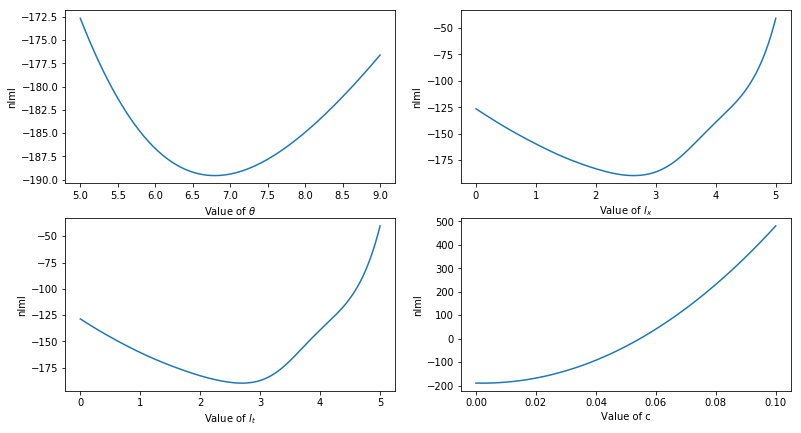

In [28]:
lin0 = np.linspace(5, 9, 200)
lin1 = np.linspace(0, 5, 200)
lin3 = np.linspace(0, 0.1, 200)
res0 = [nlml((q, m.x[1], m.x[2], m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin0]
res1 = [nlml((m.x[0], q, m.x[2], m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin1]
res2 = [nlml((m.x[0], m.x[1], q, m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin1]
res3 = [nlml((m.x[0], m.x[1], m.x[2], q), x, t, y_u, y_f, 1e-7) for q in lin3]

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=2, figsize=(13,7))
ax1[0].plot(lin0, res0)
ax1[0].set(xlabel= r"Value of $\theta$", ylabel= "nlml")
ax1[1].plot(lin1, res1)
ax1[1].set(xlabel= r"Value of $l_x$", ylabel= "nlml")
ax2[0].plot(lin1, res2)
ax2[0].set(xlabel= r"Value of $l_t$", ylabel= "nlml")
ax2[1].plot(lin3, res3)
ax2[1].set(xlabel= r"Value of c", ylabel= "nlml");

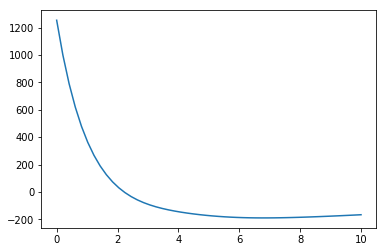

In [27]:
lin = np.linspace(0, 10, 50)
res = [nlml((q, m.x[1], m.x[2], m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res);

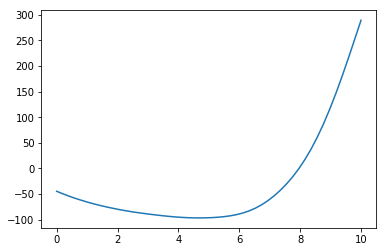

In [87]:
lin = np.linspace(0, 10, 50)
res = [nlml((m.x[0], q, m.x[2], m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res);

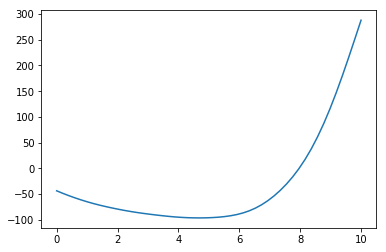

In [88]:
lin = np.linspace(0, 10, 50)
res = [nlml((m.x[0], m.x[1], q, m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res);

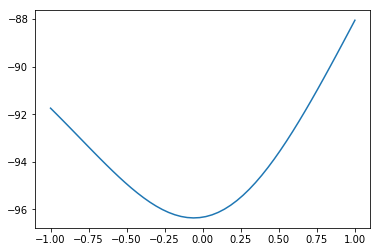

In [89]:
lin = np.linspace(-1, 1, 50)
res = [nlml((m.x[0], m.x[1], m.x[2], q), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res);

#### Step 6: Analysis of the error

In this section we want to analyze the error of our algorithm using two different ways and plot its time complexity.

In [34]:
res = np.zeros((5,25))
timing = np.zeros((5,25))
warnings.filterwarnings("ignore")
for k in range(5):
    for n in range(25):
        start_time = time.time()
        (x, t, y_u, y_f) = get_simulated_data(n)
        m = minimize(nlml, np.random.rand(4), args=(x, t, y_u, y_f, 1e-7), method="Nelder-Mead")
        res[k][n] = np.exp(m.x[3])
        timing[k][n] = time.time() - start_time

**Plotting the error in our estimate for c:**

The error is given by $| c_{estimate} - c_{true} |$

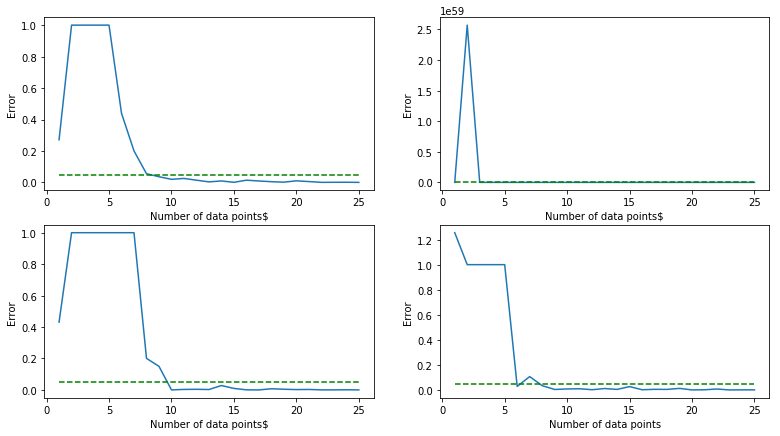

In [46]:
lin = np.linspace(1, res.shape[1], res.shape[1])
ones = np.ones(res.shape[1])
est = np.repeat(0.05, len(lin))

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=2, figsize=(13,7))
ax1[0].plot(lin, np.abs(res[0,:] - ones))
ax1[0].plot(lin, est, linestyle='dashed', color='green')
ax1[0].set(xlabel= r"Number of data points$", ylabel= "Error")
ax1[1].plot(lin, np.abs(res[1,:] - ones))
ax1[1].plot(lin, est, linestyle='dashed', color='green')
ax1[1].set(xlabel= r"Number of data points$", ylabel= "Error")
ax2[0].plot(lin, np.abs(res[2,:] - ones))
ax2[0].plot(lin, est, linestyle='dashed', color='green')
ax2[0].set(xlabel= r"Number of data points$", ylabel= "Error")
ax2[1].plot(lin, np.abs(res[3,:] - ones))
ax2[1].plot(lin, est, linestyle='dashed', color='green')
ax2[1].set(xlabel= r"Number of data points", ylabel= "Error");

All in one plot:

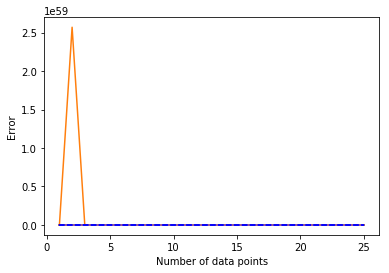

In [36]:
lin = np.linspace(1, res.shape[1], res.shape[1])

for i in range(res.shape[0]):
    plt.plot(lin, np.abs(res[i,:] - ones))
    plt.ylabel('Error')
    plt.xlabel('Number of data points')

est1 = np.repeat(0.08, len(lin))
plt.plot(lin, est1, color='blue', linestyle='dashed')
plt.show()

We see that for n sufficiently large (in this case $n \geq 10$), we can assume the error to be bounded by 0.05.

**Plotting the error between the solution and the approximative solution:**

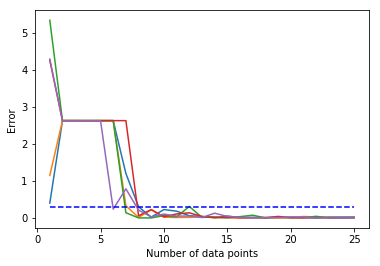

In [116]:
lin = np.linspace(1, res.shape[1], res.shape[1])
ones = np.ones(res.shape[1])
diff = np.ndarray(res.shape[1])

for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        diff[j] = np.linalg.norm((x - res[i,j]*t)**2 + \
                np.sin(x+res[i,j]*t) - (x-t)**2 - np.sin(x + t))
    plt.plot(lin, diff)
    plt.ylabel('Error')
    plt.xlabel('Number of data points')

est = np.repeat(0.3, len(lin))
plt.plot(lin, est, color='blue', linestyle='dashed')    
plt.show()

The $L^2$-error is in our case bounded by 0.3 for $n \geq 8$. 

**Plotting the execution time:**

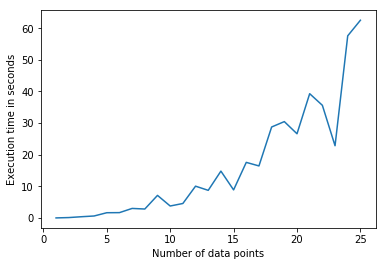

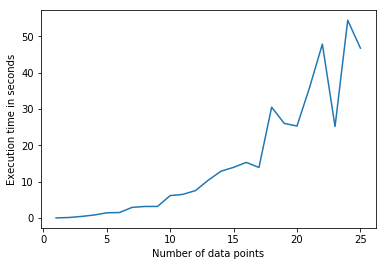

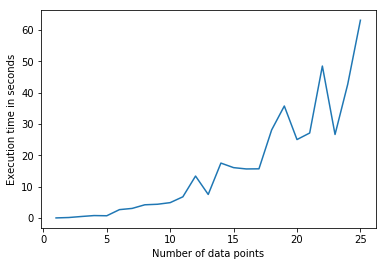

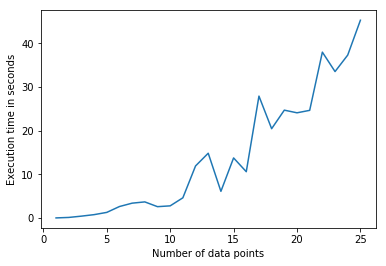

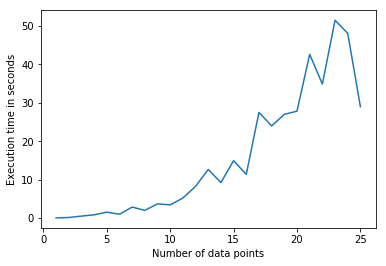

In [105]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')
    plt.show()

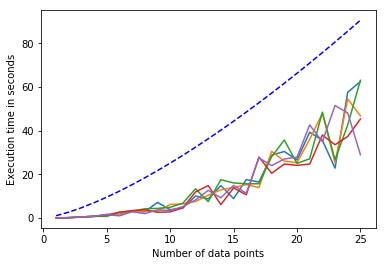

In [118]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')

est = lin**(1.4)
plt.plot(lin, est, color='blue', linestyle='dashed')
plt.show()

The time complexity seems to be around $\mathcal{O}(n^{7/5})$ (blue-dashed line).